# Environment Setup

In [45]:
# https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Mount Google Drive
!mkdir -p gdrive
!google-drive-ocamlfuse gdrive

# Change Working Directory/
import os
os.chdir('gdrive/Kaggle/Application_Screening')

gpg: keybox '/tmp/tmp3230bk6m/pubring.gpg' created
gpg: /tmp/tmp3230bk6m/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [46]:
!ls

data_exploration.ipynb	model_testing.ipynb  sample_submission.csv  train.csv
gdrive			pickles		     submissions
justins_utils.py	resources.csv	     test.csv


In [47]:
!pip install -q tqdm
!pip install -q spacy
!python -m spacy download en_core_web_md
!pip install seaborn --upgrade

import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from tqdm import tqdm

tqdm.pandas()

exec(open('justins_utils.py').read())

    100% |████████████████████████████████| 120.9MB 41.4MB/s 

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages


In [48]:
nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner'])
nlp.pipeline

[]

# EDA

## Data Prep and Initial Analysis

In [5]:
# read in and preview data
df_raw = pd.read_csv('train.csv')
peek(df_raw)

dataframe shape = (182080, 16)


,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [6]:
# get number of unique values and missing entries for each feature
ser_unique  = pd.Series(name='unique_vals',     data=df_raw.apply(lambda col: col.unique().size))
ser_missing = pd.Series(name='missing_entries', data=df_raw.isnull().sum())
ser_dtype   = pd.Series(name='dtype',           data=df_raw.dtypes)
display(pd.DataFrame([ser_unique, ser_missing, ser_dtype]).T)

del ser_unique, ser_missing, ser_dtype

,unique_vals,missing_entries,dtype
id,182080,0,object
teacher_id,104414,0,object
teacher_prefix,6,4,object
school_state,51,0,object
project_submitted_datetime,180439,0,object
project_grade_category,4,0,object
project_subject_categories,51,0,object
project_subject_subcategories,407,0,object
project_title,164282,0,object
project_essay_1,147689,0,object


In [0]:
# drop some columns, help make data easier to handle
df = df_raw.drop(columns=['project_essay_3', 'project_essay_4']) # too many missing values

del df_raw

In [0]:
def get_acc_rates(df_submits, feat):
  # dataframe of all accepted projects
  df_accepts = df_submits[df_submits['project_is_approved'] == 1]
  
  # compute total number of submissions and acceptances among all classes
  n_submits = df_submits.shape[0]
  n_accepts = df_accepts.shape[0]
  
  # create dataframe of submissions and acceptances by each class
  ser_submits = pd.Series(name='n_submits', data=df_submits[feat].value_counts())
  ser_accepts = pd.Series(name='n_accepts', data=df_accepts[feat].value_counts())
  
  rates = pd.DataFrame(data=[ser_accepts, ser_submits]).T
  
  # compute acceptance rates
  rates['acceptance_rate'] = rates['n_accepts'].div(rates['n_submits'])
  
  rates.sort_values(by='acceptance_rate', ascending=False, inplace=True)
  
  return rates

In [9]:
# compute overall acceptance rate
n_submits = df.shape[0]
n_accepts = df[df['project_is_approved'] == 1].shape[0]
acc_rate = n_accepts / n_submits

print('overall acceptance rate = {}'.format(acc_rate))
print('number of submissions = {}'.format(n_submits))

overall acceptance rate = 0.8476823374340949
number of submissions = 182080


## Non Text-Based Feature Exploration

### Initial Analysis

In [35]:
# lets look at non-text features first
# we are going to try to find the (discrete valued) features with largest standard deviation from average acceptance rate
lst_non_txt_feats = ['teacher_prefix', 
                     'school_state', 
                     'project_grade_category', 
                     'project_subject_categories', 
                     'project_subject_subcategories', 
                     'teacher_number_of_previously_posted_projects']

for feat in lst_non_txt_feats:
  ser_acc_rates = get_acc_rates(df, feat)['acceptance_rate']
  print('acceptance rate statistics for: {}'.format(feat))
  display(ser_acc_rates.describe().loc[['count', 'mean', 'std', 'min', 'max']])
  print('\n')

acceptance rate statistics for: teacher_prefix


count    5.000000
mean     0.828215
std      0.025771
min      0.794223
max      0.854085
Name: acceptance_rate, dtype: float64



acceptance rate statistics for: school_state


count    51.000000
mean      0.849713
std       0.015354
min       0.812639
max       0.891341
Name: acceptance_rate, dtype: float64



acceptance rate statistics for: project_grade_category


count    4.000000
mean     0.844949
std      0.007806
min      0.835236
max      0.853977
Name: acceptance_rate, dtype: float64



acceptance rate statistics for: project_subject_categories


count    50.000000
mean      0.816828
std       0.064309
min       0.631579
max       0.921953
Name: acceptance_rate, dtype: float64



acceptance rate statistics for: project_subject_subcategories


count    404.000000
mean       0.814278
std        0.114948
min        0.333333
max        1.000000
Name: acceptance_rate, dtype: float64



acceptance rate statistics for: teacher_number_of_previously_posted_projects


count    401.000000
mean       0.947105
std        0.071381
min        0.500000
max        1.000000
Name: acceptance_rate, dtype: float64

standard deviations of acceptance rates across each feature, in descending order:
* project_subject_subcategories:                0.1149
* teacher_number_of_previously_posted_projects: 0.0713
* project_subject_categories:                   0.0643
* teacher_prefix:                               0.0258
* school_state:                                 0.0153
* project_grade_category:                       0.0078

the best predictors of acceptance seem to be subject subcategories, number of previously posted projects, and subject categories.

### Teacher Number of Previously Posted Projects

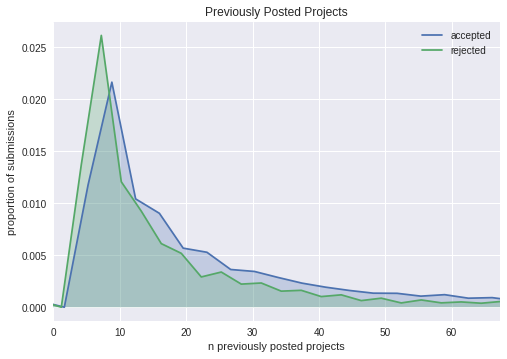

In [37]:
fix, ax = plt.subplots(1, 1)
sns.kdeplot(data=df[df['project_is_approved'] == 1]['teacher_number_of_previously_posted_projects'], shade=True, ax=ax)
sns.kdeplot(data=df[df['project_is_approved'] == 0]['teacher_number_of_previously_posted_projects'], shade=True, ax=ax)

mean = df['teacher_number_of_previously_posted_projects'].mean()
std  = df['teacher_number_of_previously_posted_projects'].std()
ax.set(title='Previously Posted Projects', xlim=[0, mean+2*std], xlabel='n previously posted projects', ylabel='proportion of submissions');

for txt, lgd in zip(ax.get_legend().texts, ['accepted', 'rejected']):
  txt.set_text(lgd)

looks like the teacher's number of previously posted projects could be a useful feature, accepted applications have a slight tendency to come from teachers with a larger number of previously posted projects

### Teacher Prefix

In [89]:
df_prefix = get_acc_rates(df, 'teacher_prefix')
display(df_prefix)

,n_accepts,n_submits,acceptance_rate
Mrs.,81484,95405,0.854085
Ms.,54854,65066,0.843052
Mr.,14876,17667,0.842022
Dr.,21,26,0.807692
Teacher,3107,3912,0.794223


among well represented prefixes (>2500 submissions) the most significant difference is if the prefix used is 'Teacher'. Married women seem to do slightly better on average than unmarried women

### School State

representing 63693/182080 = 34.9807776801406% of total submissions


,n_accepts,n_submits,acceptance_rate,perc_total,acceptance_rate-mean
TX,10036,12304,0.815670,0.067575,-0.034043
FL,8541,10359,0.824500,0.056893,-0.025212
OH,3607,4139,0.871467,0.022732,0.021754
CT,2410,2766,0.871294,0.015191,0.021582
WA,3388,3903,0.868050,0.021436,0.018338
LA,3291,3946,0.834009,0.021672,-0.015703
GA,5535,6636,0.834087,0.036446,-0.015626
OK,3195,3829,0.834422,0.021029,-0.015291
SC,5590,6463,0.864923,0.035495,0.015211
UT,2350,2814,0.835110,0.015455,-0.014602


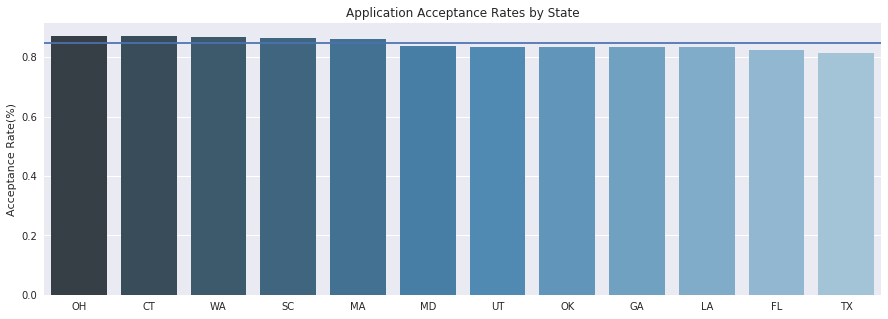

In [26]:
# get acceptance rates by state
df_state = get_acc_rates(df, 'school_state')

df_state['perc_total'] = df_state['n_submits'] / n_submits

# compute deviations from mean
df_state['acceptance_rate-mean']     = df_state['acceptance_rate'] - df_state['acceptance_rate'].mean()
df_state['acceptance_rate-mean_abs'] = df_state['acceptance_rate-mean'].abs()

# only show states with >2500 submissions and >1% deviation from mean
df_state = df_state[(df_state['perc_total'] > 0.01) & (df_state['acceptance_rate-mean_abs'] > 0.01)]

print('representing {}/{} = {}% of total submissions'.format(df_state['n_submits'].sum(), df.shape[0], df_state['n_submits'].sum() / df.shape[0] * 100))
display(df_state.sort_values(by='acceptance_rate-mean_abs', ascending=False).drop(columns='acceptance_rate-mean_abs'))

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=df_state.index, y=df_state['acceptance_rate'], palette='Blues_d', ax=ax)
ax.set(title='Application Acceptance Rates by State', ylabel='Acceptance Rate(%)')
ax.axhline(y=0.8476, xmin=0, xmax=1);

**Observations**

looks like this reduced form will end up being a useful feature. 

- Applications from southern states appear to have a reduced chance of acceptance
- After filtering, we have 12 features that are represented in 34.98% of samples
- There is a 6% swing in acceptance rates between the minimum and maximum rate among states with >1% of total submissions

In [22]:
df_state.index.values.tolist()

['OH', 'CT', 'WA', 'SC', 'MA', 'UT', 'OK', 'GA', 'LA', 'FL', 'TX']

### Project Grade Category

In [45]:
grade_rates = get_acc_rates(df, 'project_grade_category')
grade_rates

,n_accepts,n_submits,acceptance_rate
Grades 3-5,52675,61682,0.853977
Grades PreK-2,62594,73890,0.847124
Grades 6-8,23783,28197,0.843459
Grades 9-12,15294,18311,0.835236


could end up being somewhat useful

## Time-Based Feature Exploration

In [0]:
def time_str_to_float(str_time, delim=':'):
  hrs, mins, secs = [int(x) for x in str_time.split(delim)]
  float_hrs = hrs + (mins/60) + (secs/3600)
  return float_hrs


def date_str_to_float(str_date, delim='-'):
  year, month, day = [int(x) for x in str_date.split(delim)]
  float_months = month + (day/30.42)
  return float_months

In [36]:
# will be modifying this slice of the original dataframe
df_time = df[['project_is_approved', 'project_submitted_datetime']].copy()

# separate date and time into distinct features
df_time['date'] = df_time['project_submitted_datetime'].apply(lambda x: x.split(' ')[0])
df_time['time'] = df_time['project_submitted_datetime'].apply(lambda x: x.split(' ')[1])

# this columns information has been split into two distinct columns, no longer needed
df_time.drop(columns='project_submitted_datetime', inplace=True)

# the year gets to be its own feature
df_time['year'] = df_time['date'].apply(lambda x: x.split('-')[0])

# convert dates and times in to float representions of months and hours, respectively
df_time['time'] = df_time['time'].apply(lambda x: time_str_to_float(x))
df_time['date'] = df_time['date'].apply(lambda x: date_str_to_float(x))

peek(df_time)

dataframe shape = (182080, 4)


,project_is_approved,date,time,year
0,1,11.591716,14.766389,2016
1,0,4.854701,15.957778,2017
2,1,1.032873,22.962222,2017
3,0,8.394477,15.703056,2016
4,1,8.197239,9.153056,2016


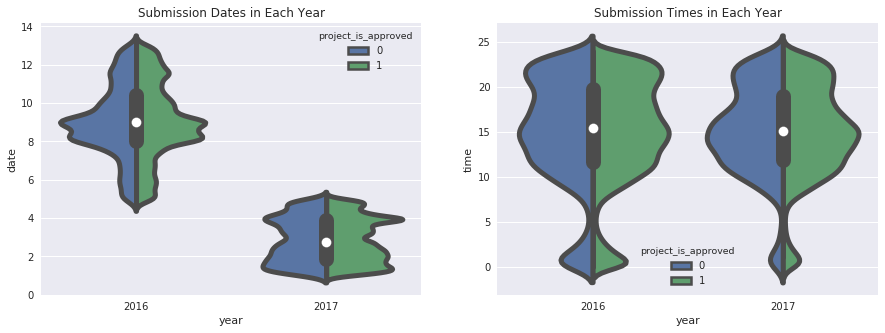

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set(title='Submission Dates in Each Year')
sns.violinplot(data=df_time,
               x='year', y='date', 
               hue='project_is_approved', 
               split=True,
               linewidth=5,
               ax=ax1);

ax2.set(title='Submission Times in Each Year')
sns.violinplot(data=df_time,
               x='year', y='time', 
               hue='project_is_approved', 
               split=True, 
               linewidth=5,
               ax=ax2);

**Observations**

looks like our data spans about one year: from May 2016 to May 2017. time and date of submission don't appear to be very useful for predicting project approval

## Text-Based Feature Exploration

In [0]:
!pip install -q wordcloud

import re

from nltk.stem.porter import *
from collections import Counter
from wordcloud import WordCloud

### Text Feature Exploration Functions

**Computing Cosine Similarities**

Comparing cosine similarities can tell us if there are any differences in the average word attributes between accepted and rejected cases

$ sim = \frac{u^{T}v}{||u||\,||v||} $

In [0]:
def get_cosine_sim(df, feature, target):
  # extract all text features, separate by target value
  text_pos = ' '.join([txt for txt in df[feature][df[target] == 1]])
  text_neg = ' '.join([txt for txt in df[feature][df[target] == 0]])

  # parse text with spacy
  [doc_acc, doc_rej] = nlp.pipe([text_pos, text_neg])
  
  # get average of word vectors for accepted and rejected cases
  vec_acc = doc_acc.vector
  vec_rej = doc_rej.vector
  
  # get Frobenius norm of word vectors
  norm_acc = np.linalg.norm(vec_acc)
  norm_rej = np.linalg.norm(vec_rej)
  
  return (vec_acc.T).dot(vec_rej) / (norm_acc * norm_rej)

**Text Cleaning and Preprocessing**

In [0]:
def clean_text(string):
  string = re.sub(r'\s.*', '', string)
  string = re.sub(r'\W', '', string)
  return string.strip().lower()


def filter_token(token):
  if token.is_digit or token.is_punct or token.is_space or token.like_num:
    return True
  return False


def word_count_differences(df, feature, target, word_type='lemma'):
  text_pos = ' '.join([txt for txt in df[feature][df[target] == 1]])
  text_neg = ' '.join([txt for txt in df[feature][df[target] == 0]])
  
  words_pos = []
  words_neg = []
  if word_type is 'lemma':
    [doc_pos, doc_neg] = nlp.pipe([text_pos, text_neg])
    words_pos = [clean_text(token.lemma_) for token in doc_pos if not filter_token(token)]
    words_neg = [clean_text(token.lemma_) for token in doc_neg if not filter_token(token)]
  elif word_type is 'stem':
    stemmer = PorterStemmer()
    words_pos = [stemmer.stem(clean_text(word)) for word in text_pos.split()]
    words_neg = [stemmer.stem(clean_text(word)) for word in text_neg.split()]
  
  n_words_pos = len(words_pos)
  n_words_neg = len(words_neg)
  
  counts_pos = pd.Series(dict(Counter(words_pos)))
  counts_neg = pd.Series(dict(Counter(words_neg)))
  counts_tot = counts_pos + counts_neg
  
  percentages = pd.DataFrame({'percentage_pos'  : counts_pos.div(n_words_pos), 
                              'percentage_neg'  : counts_neg.div(n_words_neg),
                              'percentage_tot'  : counts_tot.div(n_words_pos+n_words_neg)})
  
  percentages['pos-neg_percentage'] = percentages['percentage_pos'] - percentages['percentage_neg']
  percentages['sortval']            = percentages['pos-neg_percentage'].abs()
  percentages = percentages.dropna().sort_values(by='sortval', ascending=False).drop(columns='sortval')
  
  return percentages

**Text Visualization with Word Clouds**

In [0]:
def make_word_cloud(ser_txt):
  ser_txt = ser_txt.astype('str')
  txt_all = ' '.join([txt for txt in ser_txt])
  return WordCloud().generate(txt_all)


def show_word_clouds(df, col_feat, col_target='project_is_approved', n_samples=5000):
  # separate accepted and rejected cases
  df_all = df.sample(n_samples)
  df_acc = df[df[col_target] == 1].sample(n_samples)
  df_rej = df[df[col_target] == 0].sample(n_samples)
  
  # generate word clouds
  wc_acc = make_word_cloud(df_acc[col_feat])
  wc_rej = make_word_cloud(df_rej[col_feat])
  wc_all = make_word_cloud(df_all[col_feat])
  
  # plot word clouds
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 25))
  ax1.imshow(wc_acc) ; ax1.set(title='accepted')
  ax2.imshow(wc_rej) ; ax2.set(title='rejected')
  ax3.imshow(wc_all) ; ax3.set(title='all')
  
  # hide grid and tick marks
  for ax in [ax1, ax2, ax3]:
    ax.grid(False)
    ax.set(xticks=[], yticks=[])

**Finding Sentence Lengths**

In [0]:
def get_n_sents_and_avg_len(txt):
  sents = txt.split('.')
  n_sents = len(sents)
  
  total_len = 0
  for sent in sents:
    total_len += len(sent.split())
    
  avg_len = total_len / n_sents
  
  return n_sents, avg_len


def report_n_sents_and_avg_len(df, feature, target):
  # compute n_sents and avg_len and add as new columns
  df['n_sents'], df['avg_len'] = zip(*df[feature].map(get_n_sents_and_avg_len))
    
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  for ax, feat in zip(axes, ['n_sents', 'avg_len']):
    sns.kdeplot(data=df[df[target] == 1][feat], shade=True, ax=ax)
    sns.kdeplot(data=df[df[target] == 0][feat], shade=True, ax=ax)
    
    ax.set(title=feat, xlabel=feat);
    for txt, lgd in zip(ax.get_legend().texts, ['accepted', 'rejected']):
        txt.set_text(lgd)

### Project Subject Subcategories

In [10]:
df_subcats = get_acc_rates(df, 'project_subject_subcategories')
df_subcats['perc_total'] = df_subcats['n_submits'] / df.shape[0]
df_subcats['rate-mean']  = df_subcats['acceptance_rate'] - acc_rate

# many of the subcategories have very few submissions, lets get rid of those
df_subcats = df_subcats[(df_subcats['perc_total'] > 0.01) & (df_subcats['rate-mean'].abs() > 0.01)]

df_subcats['sortval']   = df_subcats['rate-mean'].abs()
df_subcats = df_subcats.sort_values(by='sortval', ascending=False).drop(columns='sortval')

print('percentage of total submissions represented = {}'.format(df_subcats['n_submits'].sum() / df.shape[0]))
display(df_subcats)

NameError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


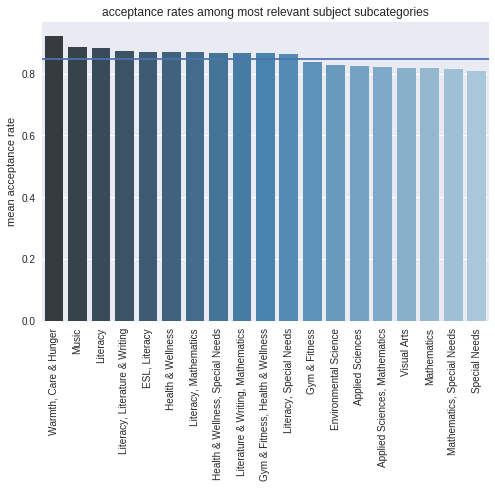

In [33]:
# visualize differences in acceptance rates among most submitted subcategories
fig, ax = plt.subplots()
df_subcats.sort_values(by='acceptance_rate', ascending=False, inplace=True)
sns.barplot(x=df_subcats.index, y=df_subcats['acceptance_rate'], palette='Blues_d', ax=ax)
ax.axhline(y=0.8476, xmin=0, xmax=1)
ax.set(title='acceptance rates among most relevant subject subcategories', ylabel='mean acceptance rate')
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=90);

**Observations**

- The 'relevant' subject subcategories are defined as the subcategories that make up >1% of the total submissions, as well as having a greater than 1% difference when compared to the mean acceptance rate. 

- These 19 chosen subcategories capture 59.5% of all submissions

- The most highly accepted subcategories are dominated by literature and literacy. Of these 19 most submitted subcategories, most of the more highly accepted subcategories involve literature or literacy. Math, Science, and special needs requests have a lower chance of acceptance.

- It looks like a lot of these subcategories have very similar meanings, we can probably do better if we extract specific words to generate our own features

In [34]:
lemma_count_diffs = word_count_differences(df, 'project_subject_subcategories', 'project_is_approved', word_type='lemma')
lemma_count_diffs.head(5)

,percentage_neg,percentage_pos,percentage_tot,pos-neg_percentage
literacy,0.098515,0.124136,0.120162,0.025621
writing,0.069974,0.079373,0.077915,0.009399
literature,0.069974,0.079373,0.077915,0.009399
applied,0.042262,0.037051,0.037860,-0.005210
science,0.039300,0.034215,0.035004,-0.005085


**Using Bayes' Theorem**

Our results are in the form P(X|Y), where we would instead like to have P(Y|X) for comparison. To save ourselves some expensive computation, invoke Bayes' theorem

$P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}$

In [36]:
# invoke Bayes' theorem
lemma_count_diffs['acceptance_rate'] = (lemma_count_diffs['percentage_pos'] * acc_rate) / lemma_count_diffs['percentage_tot']
lemma_count_diffs['rate-mean'] = lemma_count_diffs['acceptance_rate'] - acc_rate
lemma_count_diffs['sortval']   = lemma_count_diffs['rate-mean'].abs()
lemma_count_diffs = lemma_count_diffs.sort_values(by='sortval', ascending=False).drop(columns='sortval')

lemma_diffs_filtered = lemma_count_diffs[(lemma_count_diffs['percentage_tot'] > 0.01) & (lemma_count_diffs['rate-mean'].abs() > 0.01)]

print('percentage of total submissions represented = {}'.format(lemma_diffs_filtered['percentage_tot'].sum()))
lemma_diffs_filtered

percentage of total submissions represented = 0.6645959068073772


,percentage_neg,percentage_pos,percentage_tot,pos-neg_percentage,acceptance_rate,rate-mean
education,0.015147,0.011573,0.012127,-0.003574,0.808933,-0.038749
music,0.008572,0.011326,0.010899,0.002754,0.880913,0.033231
literacy,0.098515,0.124136,0.120162,0.025621,0.875720,0.028037
visual,0.025824,0.021196,0.021914,-0.004629,0.819908,-0.027774
early,0.017035,0.014703,0.015065,-0.002332,0.827329,-0.020353
development,0.017035,0.014703,0.015065,-0.002332,0.827329,-0.020353
environmental,0.022482,0.019407,0.019884,-0.003075,0.827347,-0.020336
science,0.039300,0.034215,0.035004,-0.005085,0.828581,-0.019101
arts,0.032060,0.028090,0.028705,-0.003970,0.829497,-0.018186
applied,0.042262,0.037051,0.037860,-0.005210,0.829586,-0.018097


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


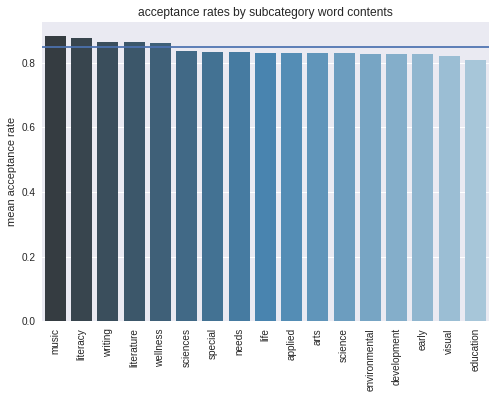

In [35]:
# visualize differences in acceptance rates among most submitted subcategories
fig, ax = plt.subplots()
filtered.sort_values(by='acceptance_rate', ascending=False, inplace=True)
sns.barplot(x=filtered.index, y=filtered['acceptance_rate'], palette='Blues_d', ax=ax)
ax.axhline(y=acc_rate, xmin=0, xmax=1)
ax.set(title='acceptance rates by subcategory word contents', ylabel='mean acceptance rate')
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=90);

**Observations**

looking at differences in acceptance rates based on difference in words used in project subject subcategories confirms some of our earlier observations, and contradicts others. 'Literacy', 'Writing', and 'Literature' are still good indicators of success, while 'Science' and 'Special' are still more likely to be rejected. 'Math' no longer appears to be a significant indicator of failure
 
- The 'relevant' keywords are defined as the keywords that appear in >1% of the total submissions, as well as having a greater than 1% difference when compared to the mean acceptance rate. 

- These 17 keywords capture 66.5% of submissions. This is an improvement from 19 chosen subcategories capturing 59.5% of all submissions.

- The keyword approach seems to have poorer performance compared to using raw features in terms of separation from the mean. However, keyword features are not mutually exclusive, unlike the raw features. This could have positive or negative effects when fed into a classifier.

- The keyword approach suffers from increased computational expense and will result in increased model complexity

In [36]:
# when converting categorical features to one-hot representations, will only consider these values
df_subcats.index.values.tolist()

['Warmth, Care & Hunger',
 'Music',
 'Special Needs',
 'Literacy',
 'Mathematics, Special Needs',
 'Mathematics',
 'Visual Arts',
 'Applied Sciences, Mathematics',
 'Literacy, Literature & Writing',
 'ESL, Literacy',
 'Applied Sciences',
 'Health & Wellness',
 'Literacy, Mathematics',
 'Health & Wellness, Special Needs',
 'Literature & Writing, Mathematics',
 'Environmental Science',
 'Gym & Fitness, Health & Wellness',
 'Literacy, Special Needs',
 'Gym & Fitness']

### Title

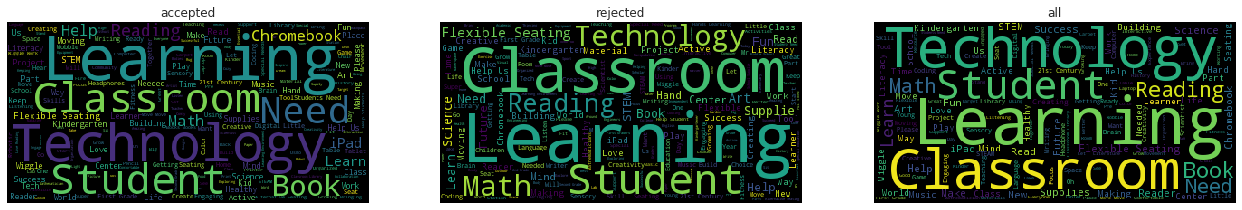

In [38]:
show_word_clouds(df, col_feat='project_title')

In [39]:
# find differences in word usage between accepted and rejected examples
lemma_diffs = word_count_differences(df, 'project_title', 'project_is_approved', word_type='lemma')
lemma_diffs.head()

,percentage_neg,percentage_pos,percentage_tot,pos-neg_percentage
for,0.030572,0.035350,0.034637,0.004778
books,0.004066,0.007200,0.006732,0.003133
supplies,0.006853,0.003920,0.004358,-0.002932
chromebooks,0.001761,0.004536,0.004122,0.002775
with,0.011450,0.014187,0.013779,0.002738


In [40]:
# invoke Bayes' theorem
lemma_diffs['acceptance_rate'] = (lemma_diffs['percentage_pos'] * acc_rate) / lemma_diffs['percentage_tot']

lemma_diffs['rate-mean'] = lemma_diffs['acceptance_rate'] - acc_rate

# sort by abs(deviation from mean)
lemma_diffs['sortval']   = lemma_diffs['rate-mean'].abs()
lemma_diffs = lemma_diffs.sort_values(by='sortval', ascending=False).drop(columns='sortval')

# filter out keywords with either poor predictive power or minimal usage
lemma_diffs_filtered = lemma_diffs[(lemma_diffs['percentage_tot'] > 0.01) & (lemma_diffs['rate-mean'].abs() > 0.01)]

print('percentage of total submissions represented = {}'.format(lemma_diffs_filtered['percentage_tot'].sum()))
lemma_diffs_filtered

percentage of total submissions represented = 0.10344791161616962


,percentage_neg,percentage_pos,percentage_tot,pos-neg_percentage,acceptance_rate,rate-mean
with,0.011450,0.014187,0.013779,0.002738,0.872841,0.025159
technology,0.008890,0.010388,0.010164,0.001498,0.866344,0.018662
for,0.030572,0.035350,0.034637,0.004778,0.865147,0.017465
a,0.019384,0.021644,0.021307,0.002260,0.861112,0.013430
our,0.012312,0.013661,0.013460,0.001349,0.860368,0.012686
classroom,0.010919,0.009959,0.010103,-0.000960,0.835650,-0.012032


**Observations**

we have 8 keywords with representation in only 10.3% of samples, and separation appears poor. Title keywords unfortunately don't look very promising as potential features.

**Computing Cosine Similarities**

Cosine similarities can tell us if there are any differences in the average word attributes between accepted and rejected cases

$ sim = \frac{u^{T}v}{||u||\,||v||} $

In [47]:
get_cosine_sim(df, 'project_title', 'project_is_approved')

0.9992659581052139

very high cosine similarity between average word vectors of positive and negative examples; won't be of any use

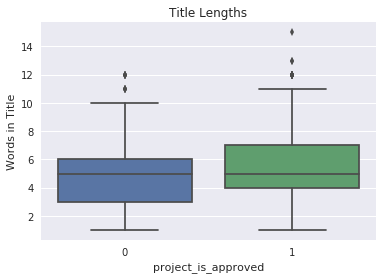

In [17]:
# compute number of words in each title
n_words = df.apply(lambda row: len(row['project_title'].split()), axis=1)

fig, ax = plt.subplots()
sns.boxplot(x=df['project_is_approved'], y=n_words, ax=ax)
ax.set(title='Title Lengths', ylabel='Words in Title');

### Project Essay 1

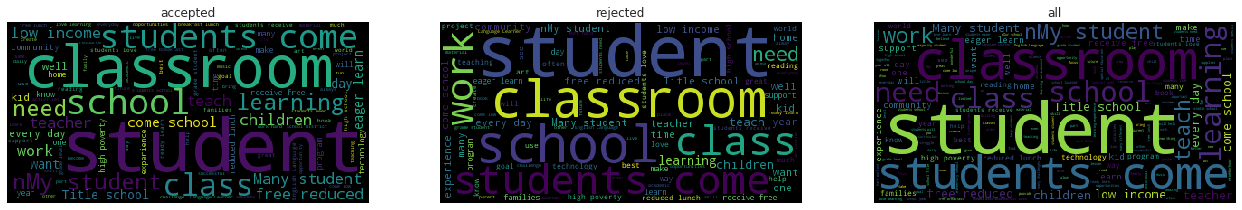

In [48]:
show_word_clouds(df, 'project_essay_1')

In [53]:
lemma_count_diffs = word_count_differences(df, 'project_essay_1', 'project_is_approved', word_type='lemma')
lemma_count_diffs.head()

,percentage_neg,percentage_pos,percentage_tot,pos-neg_percentage
school,0.015191,0.015871,0.015767,0.000680
the,0.030458,0.029804,0.029903,-0.000654
student,0.030452,0.031019,0.030933,0.000568
read,0.002290,0.002838,0.002755,0.000548
my,0.018946,0.019486,0.019404,0.000540


In [65]:
# invoke Bayes' theorem
lemma_count_diffs['acceptance_rate'] = (lemma_count_diffs['percentage_pos'] * acc_rate) / lemma_count_diffs['percentage_tot']
lemma_count_diffs['rate-mean'] = lemma_count_diffs['acceptance_rate'] - acc_rate
lemma_count_diffs['sortval']   = lemma_count_diffs['rate-mean'].abs()
lemma_count_diffs = lemma_count_diffs.sort_values(by='sortval', ascending=False).drop(columns='sortval')

lemma_diffs_filtered = lemma_count_diffs[(lemma_count_diffs['percentage_tot'] > 0.01) & (lemma_count_diffs['rate-mean'].abs() > 0.01)]

print('percentage of total submissions represented = {}'.format(lemma_diffs_filtered['percentage_tot'].sum()))
lemma_diffs_filtered

percentage of total submissions represented = 0.0


,percentage_neg,percentage_pos,percentage_tot,pos-neg_percentage,acceptance_rate,rate-mean


In [66]:
get_cosine_sim(df, 'project_essay_1', 'project_is_approved')

0.9998258953427154

looking at words individually is unhelpful for making predictions

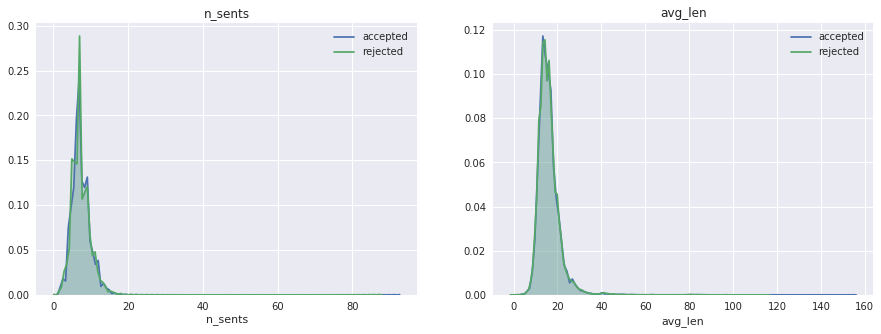

In [30]:
report_n_sents_and_avg_len(df, 'project_essay_1', 'project_is_approved')

average number of sentences and sentence length is a poor predictor for application success

### Project Essay 2

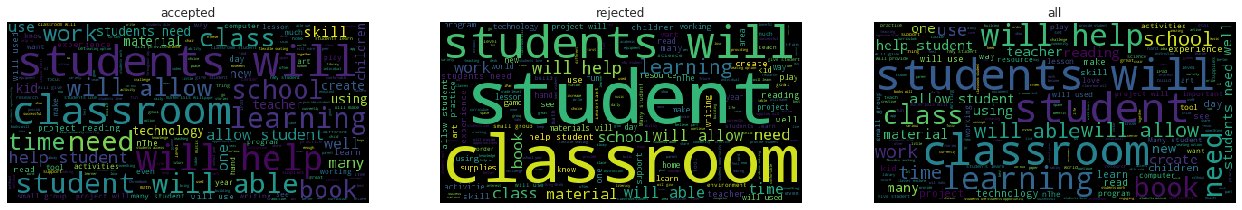

In [107]:
show_word_clouds(df, 'project_essay_2', 'project_is_approved')

In [19]:
lemma_count_diffs = word_count_differences(df.sample(10000), 'project_essay_2', 'project_is_approved', word_type='lemma')
lemma_count_diffs.head()

,percentage_neg,percentage_pos,percentage_tot,pos-neg_percentage
learn,0.011027,0.009242,0.009496,-0.001785
material,0.003836,0.002125,0.002369,-0.001710
book,0.002587,0.004286,0.004045,0.001699
use,0.006347,0.007787,0.007583,0.001440
and,0.037032,0.035671,0.035864,-0.001362


In [21]:
# invoke Bayes' theorem
lemma_count_diffs['acceptance_rate'] = (lemma_count_diffs['percentage_pos'] * acc_rate) / lemma_count_diffs['percentage_tot']
lemma_count_diffs['rate-mean'] = lemma_count_diffs['acceptance_rate'] - acc_rate
lemma_count_diffs['sortval']   = lemma_count_diffs['rate-mean'].abs()
lemma_count_diffs = lemma_count_diffs.sort_values(by='sortval', ascending=False).drop(columns='sortval')

lemma_diffs_filtered = lemma_count_diffs[(lemma_count_diffs['percentage_tot'] > 0.01) & (lemma_count_diffs['rate-mean'].abs() > 0.01)]

print('percentage of total submissions represented = {}'.format(lemma_diffs_filtered['percentage_tot'].sum()))
lemma_diffs_filtered

percentage of total submissions represented = 0.0


,percentage_neg,percentage_pos,percentage_tot,pos-neg_percentage,acceptance_rate,rate-mean


In [30]:
get_cosine_sim(df, 'project_essay_2', 'project_is_approved')

0.9997462231602356

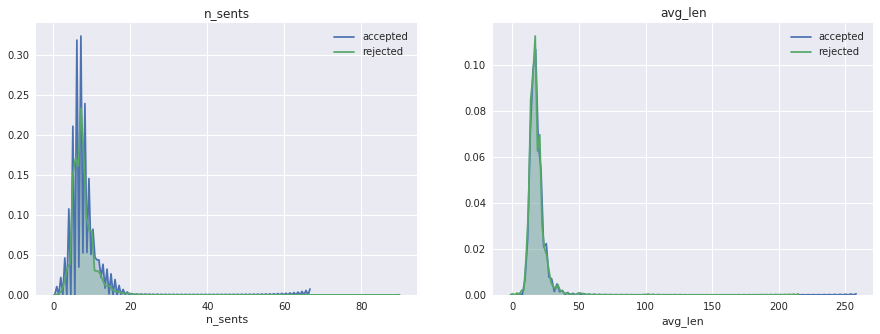

In [31]:
report_n_sents_and_avg_len(df, 'project_essay_2', 'project_is_approved')

### Project Resource Summary

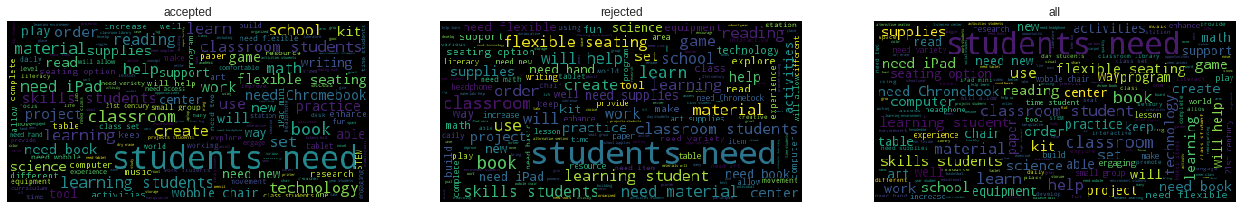

In [33]:
show_word_clouds(df, col_feat='project_resource_summary')

In [0]:
get_word_count_diffs(df, col_feat='project_resource_summary', str_type='lemma', n_samples=5000)

## Resources Exploration

In [93]:
resources_dtypes= {'id': str, 
                   'description': str, 
                   'quantity': int, 
                   'price': float}

resources = pd.read_csv('resources.csv', converters=resources_dtypes, low_memory=True)
peek(resources)

dataframe shape = (1541272, 4)


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [94]:
resources['total_price'] = resources['quantity'] * resources['price']
labeled_resources = df[['id', 'project_is_approved']].merge(resources, how='left', left_on='id', right_on='id')

peek(labeled_resources)

dataframe shape = (1081830, 6)


,id,project_is_approved,description,quantity,price,total_price
0,p036502,1,Apple - iPod nano� 16GB MP3 Player (8th Genera...,3,149.99,449.97
1,p036502,1,Apple - iPod nano� 16GB MP3 Player (8th Genera...,3,149.99,449.97
2,p039565,0,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,20,20.00,400.00
3,p233823,1,3doodler Start Full Edu Bundle,1,469.99,469.99
4,p185307,0,BALL PG 4'' POLY SET OF 6 COLORS,1,18.95,18.95


In [0]:
# show_word_clouds(labeled_resources, col_feat='description', col_target='project_is_approved')
resources_diffs = word_count_differences(labeled_resources, 'description', 'project_is_approved', word_type='lemma')
resources_diffs[(resources_diffs['percentage_tot'] > 0.01) & (resources_diffs['pos-neg_percentage'].abs() > 0.01)]

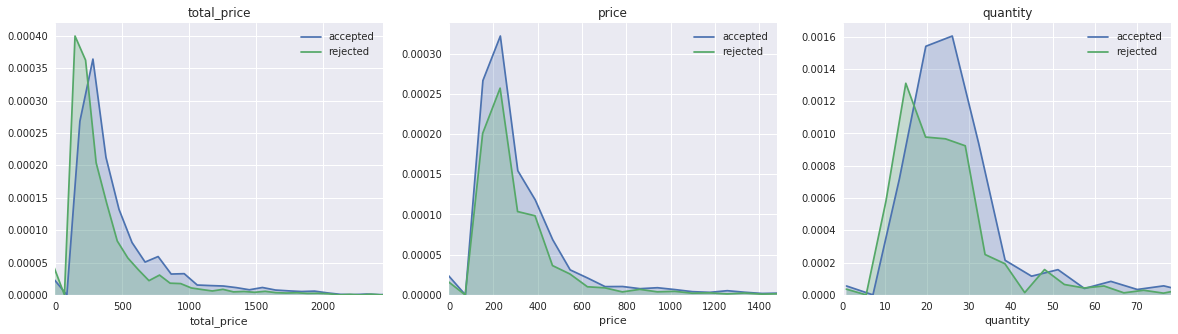

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, feature in zip(axes, ['total_price', 'price', 'quantity']):
  sns.kdeplot(data=labeled_resources[labeled_resources['project_is_approved'] == 1][feature], shade=True, ax=ax)
  sns.kdeplot(data=labeled_resources[labeled_resources['project_is_approved'] == 0][feature], shade=True, ax=ax)
  
  mean = labeled_resources[feature].mean()
  std  = labeled_resources[feature].std()
  
  ax.set(title=feature, xlim=[0,mean+10*std], xlabel=feature)
  
  for txt, lgd in zip(ax.get_legend().texts, ['accepted', 'rejected']):
    txt.set_text(lgd)

it should be noted that the plots do not show all of the data, due to how many outliers are present.
Surprisingly, the amount of the request doesn't appear to be a very good predictor of project approval. 

# Model Testing  

In [0]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Concatenate, CuDNNGRU, Dropout, BatchNormalization
from keras.layers import TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping

from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import LabelBinarizer

import pickle

## Data Prep

In [0]:
dtypes = {
    'id': str,
    'teacher_id': str,
    'teacher_prefix': str,
    'school_state': str,
    'project_submitted_datetime': str,
    'project_grade_category': str,
    'project_subject_categories': str,
    'project_subject_subcategories': str,
    'project_title': str,
    'project_essay_1': str,
    'project_essay_2': str,
    'project_essay_3': str,
    'project_essay_4': str,
    'project_resource_summary': str,
    'teacher_number_of_previously_posted_projects': int,
    'project_is_approved': np.uint8,
}

df = pd.read_csv('train.csv', converters=dtypes, low_memory=True)

In [0]:
def preprocess_txt_for_training(ser, shape):
  print('getting docs...')
  nlp.add_pipe(nlp.create_pipe('sentencizer'))
  docs = list(ser.progress_map(lambda x: nlp(x)))
  nlp.remove_pipe('sbd')
  
  print('getting sentences...')
  max_n_sents = shape['max_n_sents']
  max_sent_len = shape['max_sent_len']
  
  X = np.zeros((len(docs), max_n_sents, max_sent_len))
  
  for i, doc in enumerate(docs):
    for j, sent in enumerate(doc.sents):
      if j >= max_n_sents: break
      for k, token in enumerate(sent):
        if k >= max_sent_len: break
        X[i, j, k] = token.vocab.vectors.find(key=token.orth)
  
  return X


def get_features(df, binarizers):
  # unpack binarizers
  prefix_binarizer = binarizers['prefix']
  state_binarizer  = binarizers['state']
  subcat_binarizer = binarizers['subcat']
  
  # one hot encoding for categorical features
  X_prefix = prefix_binarizer.transform(df['teacher_prefix'])
  X_state  = state_binarizer.transform(df['school_state'])
  X_subcat = subcat_binarizer.transform(df['project_subject_subcategories'])
  
  # continuous features
  X_prev_posted = df['teacher_number_of_previously_posted_projects'].values
  
#   essay_1_file = open('pickles/essay_1_{}k'.format(int(df.shape[0] / 1000)), 'r+b')
#   essay_2_file = open('pickles/essay_2_{}k'.format(int(df.shape[0] / 1000)), 'r+b')
  
#   X_essay_1 = pickle.load(essay_1_file)
#   X_essay_2 = pickle.load(essay_2_file)
    
  # preprocess text data
  X_essay_1 = preprocess_txt_for_training(df['project_essay_1'], shape)
  X_essay_2 = preprocess_txt_for_training(df['project_essay_2'], shape)
    
    
  print(
      '{:<20} = {}'.format('X_prev_posted.shape', X_prev_posted.shape), '\n'
      '{:<20} = {}'.format('X_subcat.shape',      X_subcat.shape),      '\n'
      '{:<20} = {}'.format('X_prefix.shape',      X_prefix.shape),      '\n'
      '{:<20} = {}'.format('X_state.shape',       X_state.shape),       '\n'
      '{:<20} = {}'.format('X_essay_1.shape',     X_essay_1.shape),     '\n'
      '{:<20} = {}'.format('X_essay_2.shape',     X_essay_2.shape)
       )
  
  return [X_prev_posted, X_subcat, X_prefix, X_state, X_essay_1, X_essay_2]

In [0]:
# shape = {'max_sent_len': 12,
#          'max_n_sents': 27}

shape = {'max_sent_len': 50,
         'max_n_sents': 30}

settings = {'dropout': 0.2}

seed=0

In [53]:
# determined which categorical values to consider during data exploration (for binarizers)
prefixes_to_keep = ['Teacher']
states_to_keep   = ['OH', 'CT', 'WA', 'SC', 'MA', 'UT', 'OK', 'GA', 'LA', 'FL', 'TX']
subcats_to_keep  = ['Warmth, Care & Hunger', 'Music', 'Special Needs', 'Literacy', 'Mathematics, Special Needs', 'Mathematics', 'Visual Arts', 'Applied Sciences, Mathematics', 'Literacy, Literature & Writing', 'ESL, Literacy', 'Applied Sciences', 'Health & Wellness', 'Literacy, Mathematics', 'Health & Wellness, Special Needs', 'Literature & Writing, Mathematics', 'Environmental Science', 'Gym & Fitness, Health & Wellness', 'Literacy, Special Needs', 'Gym & Fitness']
# chance of some categorical values not being represented in sample, fit binarizers to entire dataset beforehand to ensure consistency
binarizers = {'prefix': LabelBinarizer().fit(df[df['teacher_prefix'].isin(prefixes_to_keep)]['teacher_prefix']),
              'state' : LabelBinarizer().fit(df[df['school_state']  .isin(states_to_keep  )]['school_state']),
              'subcat': LabelBinarizer().fit(df[df['project_subject_subcategories'].isin(subcats_to_keep)]['project_subject_subcategories'])}

df_sample = df.sample(n=40000, random_state=seed)
# df_sample = df

# extract features from sampled dataset
X_tr = get_features(df_sample, binarizers)
y_tr = df_sample['project_is_approved'].values

  0%|          | 34/40000 [00:00<01:59, 334.42it/s]

getting docs...


100%|██████████| 40000/40000 [02:07<00:00, 312.78it/s]


getting sentences...


  0%|          | 26/40000 [00:00<02:39, 250.47it/s]

getting docs...


100%|██████████| 40000/40000 [02:37<00:00, 253.72it/s]


getting sentences...
X_prev_posted.shape  = (40000,) 
X_subcat.shape       = (40000, 19) 
X_prefix.shape       = (40000, 1) 
X_state.shape        = (40000, 11) 
X_essay_1.shape      = (40000, 30, 50) 
X_essay_2.shape      = (40000, 30, 50)


## Model Setup

In [0]:
def essay_model_setup(embeddings, shape, settings):
  # unpack hyperparams
  max_sent_len  = shape['max_sent_len']
  max_n_sents   = shape['max_n_sents']
  
  dropout = settings['dropout']
  
  # predefine embedding layer for readability
  embedding_layer = Embedding(input_dim=embeddings.shape[0],
                              output_dim=embeddings.shape[1],
                              input_length=max_sent_len,
                              trainable=False,
                              weights=[embeddings],
                              name='embedding_layer')
 
  
  # sentence encoder
  sent_in    = Input(shape=(max_sent_len,), dtype='int32', name='sentence_in')
  sent_embed = embedding_layer(sent_in)
  sent_lstm  = Bidirectional(CuDNNGRU(units=16, return_sequences=True, name='bidirectional_GRU'))(sent_embed)
  sent_dense = TimeDistributed(Dense(8, activation='relu', name='distributed_dense'))(sent_lstm)
  sent_out   = Bidirectional(CuDNNGRU(units=4, name='bidirectional_GRU_2'))(sent_dense)
  sent_encoder = Model(inputs=sent_in, outputs=sent_out)
  
  # essay model
  txt_in      = Input(shape=(max_n_sents, max_sent_len), dtype='int32', name='essay_in')
  txt_encoded = TimeDistributed(sent_encoder)(txt_in)
  txt_lstm    = Bidirectional(CuDNNGRU(units=32, return_sequences=True))(txt_encoded)
  txt_dense   = TimeDistributed(Dense(16, activation='relu'))(txt_lstm)
  txt_out     = Bidirectional(CuDNNGRU(units=8))(txt_dense)
  essay_model = Model(inputs=txt_in, outputs=txt_out)
  
  # full model
  essay_1_in  = Input(shape=(max_n_sents, max_sent_len), dtype='int32', name='essay_1_in')
  essay_2_in  = Input(shape=(max_n_sents, max_sent_len), dtype='int32', name='essay_2_in')
  essay_1_rnn = essay_model(essay_1_in)
  essay_2_rnn = essay_model(essay_2_in)
  
  # auxillary inputs
  n_prev_posted  = Input(shape=(1,),  dtype='float32', name='n_previously_posted')
  subj_subcat    = Input(shape=(19,), dtype='float32', name='project_subcategory')
  prefix         = Input(shape=(1,),  dtype='float32', name='teacher_prefix')
  state          = Input(shape=(11,), dtype='float32', name='state')
  
  full_concat = Concatenate(axis=1)([
                                     n_prev_posted, 
                                     subj_subcat, 
                                     prefix, 
                                     state, 
                                     essay_1_rnn, 
                                     essay_2_rnn
                                    ])
  full_out   = Dense(1, activation='sigmoid')(full_concat)
  
  full_model = Model(inputs=[n_prev_posted, subj_subcat, prefix, state, essay_1_in, essay_2_in], outputs=full_out)
  
  full_model.compile(loss='binary_crossentropy', 
                     optimizer='adadelta', 
                     metrics=['accuracy'], 
                     )
  
  print('\nsent_encoder summary'); sent_encoder.summary()
  print('\nrnn_model summary');    essay_model.summary()
  print('\nfull_model summary');   full_model.summary()
  
  return full_model

In [55]:
# retrieve word embeddings
embeddings = nlp.vocab.vectors.data

model = essay_model_setup(embeddings, shape, settings)


sent_encoder summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_in (InputLayer)     (None, 50)                0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 50, 300)           6000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 32)            30528     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 50, 8)             264       
_________________________________________________________________
bidirectional_6 (Bidirection (None, 8)                 336       
Total params: 6,031,128
Trainable params: 31,128
Non-trainable params: 6,000,000
_________________________________________________________________

rnn_model summary
_________________________________________________________________
Layer (type)        

**removed dropout, CuDNNLSTM**
val_loss: 0.6155 - val_acc: 0.6688

**CuDNNGRU**
val_loss: 0.6135 - val_acc: 0.6760

**modified features**
val_loss: 0.6085 - val_acc: 0.6708

**subject subcategories to individual words**
val_loss: 0.6005 - val_acc: 0.6868

**removed states w/ >1% effect, >1000 submissions**
val_loss: 0.6119 - val_acc: 0.6688

**removed states w/ >1% effect, >2500 submissions**
val_loss: 0.5935 - val_acc: 0.6932

**50,000 samples w/ class weights**
val_loss: 0.6217 - val_acc: 0.6564

**all w/ class weights**
val_loss: 0.5991 - val_acc: 0.6805

**40,000 samples w/ class weights**
val_loss: 0.5738 - val_acc: 0.7635

**added BatchNormalization**
val_loss: 0.5916 - val_acc: 0.7125

**added 'Mrs.'**
val_loss: 0.6019 - val_acc: 0.7065

**added title keywords**
val_loss: 0.5887 - val_acc: 0.7735

**changed subject subcats back from keywords**
val_loss: 0.5852 - val_acc: 0.7140

**(30, 50) essay embeddings**
val_loss: 0.5756 - val_acc: 0.8045

In [56]:
# need to weight classes to counter imbalance
class_weights = class_weight.compute_class_weight('balanced', [0, 1], y_tr)
class_weights = dict(zip([0, 1], class_weights))
print('class weights = {}'.format(class_weights))

# train model
model.fit(X_tr, y_tr, validation_split=0.05, batch_size=32, epochs=10, class_weight=class_weights, callbacks=[EarlyStopping()])

class weights = {0: 3.2943501894251357, 1: 0.5894662383212002}
Train on 38000 samples, validate on 2000 samples
Epoch 1/10
30720/38000 [=======================>......] - ETA: 26s - loss: 0.8132 - acc: 0.5479

38000/38000 [==============================] - 140s 4ms/step - loss: 0.7842 - acc: 0.5539 - val_loss: 0.6276 - val_acc: 0.7290
Epoch 2/10
25856/38000 [===================>..........] - ETA: 43s - loss: 0.6370 - acc: 0.6448

38000/38000 [==============================] - 138s 4ms/step - loss: 0.6289 - acc: 0.6575 - val_loss: 0.5918 - val_acc: 0.7405
Epoch 3/10
24064/38000 [=================>............] - ETA: 49s - loss: 0.6102 - acc: 0.7012

38000/38000 [==============================] - 138s 4ms/step - loss: 0.6110 - acc: 0.7002 - val_loss: 0.5843 - val_acc: 0.6585
Epoch 4/10
23360/38000 [=================>............] - ETA: 52s - loss: 0.6027 - acc: 0.7030

38000/38000 [==============================] - 138s 4ms/step - loss: 0.6006 - acc: 0.7098 - val_loss: 0.5847 - val_acc: 0.7580


# Final Submission

In [0]:
df_tst = pd.read_csv('test.csv', converters=dtypes, low_memory=True)

In [51]:
X_tst = get_features(df_tst, binarizers)

getting docs...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-835bdce41adb>", line 1, in <module>
    X_tst = get_features(df_tst, binarizers)
  File "<ipython-input-43-94a9551abc66>", line 69, in get_features
    X_essay_1 = preprocess_txt_for_training(df['project_essay_1'], shape)
  File "<ipython-input-43-94a9551abc66>", line 43, in preprocess_txt_for_training
    print('getting docs...');      docs = get_docs(ser)
  File "<ipython-input-43-94a9551abc66>", line 19, in get_docs
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
  File "/usr/local/lib/python3.6/dist-packages/spacy/language.py", line 271, in add_pipe
    raise ValueError(Errors.E007.format(name=name, opts=self.pipe_names))
ValueError: [E007] 'sbd' already exists in pipeline. Existing names: ['sbd']

During handling of the above exception, another exception occurred:

ValueError: ignored

In [35]:
preds = model.predict(X_tst, verbose=1)

78035/78035 [==============================] - 108s 1ms/step


In [0]:
submit = pd.DataFrame({'id': df_tst['id'], 
                       'project_is_approved': preds.ravel()})

submit.to_csv('submissions/6.csv', index=None)